# ImageNet-1K Dataset Analysis

Here we analyze the Imagenet-1K dataset to understand the distribution of ViT feature embeddings.

In [1]:
import numpy as np
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from hips.plotting.layout import create_axis_at_location

sns.set_context("paper")
sns.set_style("ticks")

## Load the Imagenet-1K and OpenOOD ViT features

In [2]:
torch.manual_seed(0)
features_type = "vit-b-16"
id_tr_dataset = torch.load(features_type + "-img1k-feats.pkl")
X_tr_raw = id_tr_dataset["feats"]
y_tr = id_tr_dataset["labels"].long()

id_te_dataset = torch.load(features_type + "-img1k-test-feats.pkl")
X_te_raw = id_te_dataset["feats"]
y_te = id_te_dataset["labels"].long()

ood_datasets = dict(
    near=dict(
        ssb_hard=torch.load(features_type + "-img1k-near-ssb_hard-feats.pkl"),
        ninco=torch.load(features_type + "-img1k-near-ninco-feats.pkl"),
    ),
    far=dict(
        inaturalist=torch.load(features_type + "-img1k-far-inaturalist-feats.pkl"),
        openimage_o=torch.load(features_type + "-img1k-far-openimage_o-feats.pkl"),
        textures=torch.load(features_type + "-img1k-far-textures-feats.pkl"),
    ),
)
ood_dataset = ood_datasets["near"]["ssb_hard"]
X_ood = ood_dataset["feats"]
y_ood = ood_dataset["labels"].long()

X_te_raw = torch.cat([X_te_raw, X_ood], 0)
y_te = torch.cat([y_te, y_ood], 0)

K = y_tr.max() + 1

print(f"Number of training classes: {K}")
print(f"Samples in train set: {X_tr_raw.shape[0]}")
print(f"ID samples in test set: {len(X_te_raw[y_te != -1])}")
print(f"OOD samples in test set: {len(X_te_raw[y_te == -1])}")

Number of training classes: 1000
Samples in train set: 1281166
ID samples in test set: 45000
OOD samples in test set: 49000


## Discard PCs with small eigenvalues

In [3]:
C = torch.cov(X_tr_raw.T)

evals, evecs = torch.linalg.eigh(C)
evals = evals.flip(0)
evecs = evecs.flip(1)
thresh = evals.max() * C.shape[-1] * 1e-7
keep = evals > thresh
print(f"keeping {keep.sum()} of {len(keep)} PCs")

X_mean = X_tr_raw.mean(0)
proj = lambda X: (X - X_mean) @ evecs[:, keep] / evals[keep].sqrt()
X_tr = proj(X_tr_raw)
X_te = proj(X_te_raw)

for k,v in ood_datasets.items():
    for kk,vv in v.items():
        vv["feats"] = proj(vv["feats"])

keeping 765 of 768 PCs


## Project into eigenbasis of average within-class covariance

In [4]:
muk_hat = torch.stack([X_tr[y_tr == k].mean(0) for k in range(K)])
Psi0_star = torch.einsum('ni,nj->ij', X_tr - muk_hat[y_tr], X_tr - muk_hat[y_tr]) / len(X_tr)
evals, evecs = torch.linalg.eigh(Psi0_star)
Z_tr = X_tr @ evecs
Z_te = X_te @ evecs

for k,v in ood_datasets.items():
    for kk,vv in v.items():
        vv["feats"] = vv["feats"] @ evecs
D = Z_tr.shape[-1]

## Within-class vs marginal covariances

(0.0, 10.0)

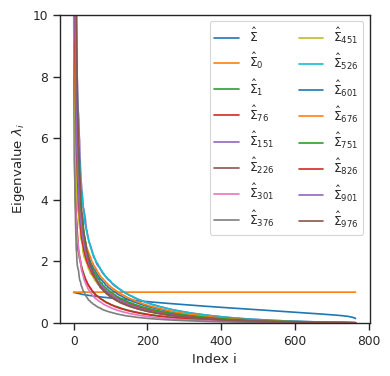

In [5]:
mu0_star = X_tr.mean(0)
Sigma0_star = torch.einsum('ni,nj->ij', X_tr - mu0_star, X_tr - mu0_star) / len(X_tr)
Sigmak_star = torch.stack(
    [torch.einsum('ni,nj->ij', X_tr[y_tr==k] - muk_hat[k], X_tr[y_tr==k] - muk_hat[k]) / (y_tr==k).sum()
     for k in range(K)])
fig = plt.figure(figsize=(4, 4))
plt.plot(evals.flip(0), label=r"$\hat{\Sigma}$")
plt.plot(torch.linalg.eigh(Sigma0_star)[0].flip(0), label=r"$\hat{\Sigma}_0$")
for k in range(1,K,75):
    plt.plot(torch.linalg.eigh(Sigmak_star[k])[0].flip(0), label=rf"$\hat{{\Sigma}}_{{{k}}}$")
plt.legend(ncol=2)
plt.ylabel(r"Eigenvalue $\lambda_i$")
plt.xlabel("Index i")
plt.ylim(0, 10)
# plt.savefig("empirical-cov-eigenspectra.pdf", bbox_inches="tight")

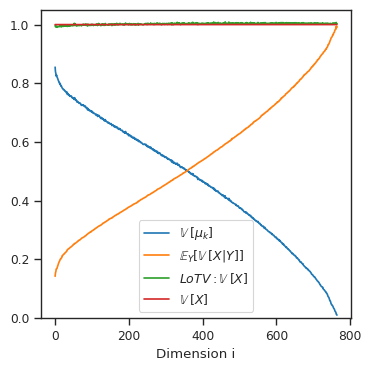

In [6]:
# Variance of the means
fig, ax = plt.subplots(figsize=(4, 4))
Z_muk_hat = torch.stack([Z_tr[y_tr == k].mean(0) for k in range(K)])
V_muk = Z_muk_hat.var(0)
plt.plot(V_muk, label=r"$\mathbb{V}\ [\mu_k]$")

# Average within class variance
E_V_within = torch.stack([Z_tr[y_tr == k].var(0) for k in range(K)]).mean(0)
plt.plot(E_V_within, label=r"$\mathbb{E}_Y[\mathbb{V}\ [X|Y]]$")

# Law of total variance
V_total = E_V_within + V_muk
plt.plot(V_total, label=r"$LoTV: \mathbb{V}\ [X]$")

plt.plot(Z_tr.var(0), label=r"$\mathbb{V}\ [X]$")
plt.xlabel("Dimension i")
plt.ylim(0, 1.05)
plt.legend(loc="lower center",
           fontsize=9)
# plt.savefig("lotv-decomposition.pdf", bbox_inches="tight")

## Plot the variance by dimension for each class

In [7]:
diag_Sigma0_star = torch.var(Z_tr, 0)
sigmasqk_star = torch.stack([torch.var(Z_tr[y_tr==k], 0) for k in range(K)])
diag_Psi0_star = sigmasqk_star.mean(0)

currently plotting : [363, 418, 428, 452, 458]


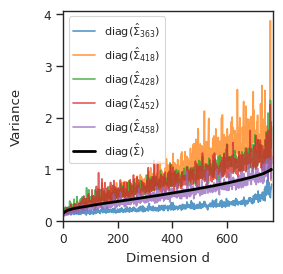

In [16]:
rng = torch.Generator().manual_seed(10)
ks2plot = [363, 418, 428, 452, 458]
print(f"currently plotting : {ks2plot}")
fig = plt.figure(figsize=(3.25, 2.6))
ax = create_axis_at_location(fig, 0.6, 0.42, 2.1, 2.1)
for k in ks2plot:
    plt.plot(sigmasqk_star[k],
             label=rf"$\mathrm{{diag}}(\hat{{\Sigma}}_{{{k}}})$",
             alpha=0.75)
plt.plot(diag_Psi0_star, "k-", lw=2,
         label=r"$\mathrm{diag}(\hat{\Sigma})$"
)
plt.ylabel("Variance", labelpad=15)
plt.xlabel("Dimension d")
plt.xlim(0, 770)
plt.ylim(0,)
plt.legend(fontsize=8)
plt.savefig("empirical-cov-diag.pdf")#, bbox_inches="tight")

## Visualize the class covariance deviation from the average covariance of the diagonal elements

In the above plot we identify that the diagonal elements of the class covariances seem to be a scaled up or down version of the diagonal elements of the average covariance. In other words, the class covariances are coupled over dimension which motivates our coupled diagonal covariance hierarchical DPMM model.

However, the above plot only shows 5 classes. To get a better sense of the full distribution we plot the correlation coefficients of the deviation from the average covariance for all classes.
$$
\mathrm{dev}_k \coloneqq \mathrm{diag}(\hat{\Sigma}_k) - \mathrm{diag}(\hat{\Sigma}) \\
\mathrm{corr}_k(\mathrm{dev}_{k,i}, \mathrm{dev}_{k,j})_{i,j \in {1, \ldots, d}}
$$

In [9]:
# Calculate difference of sigma_kd to mean ()
diff_sigmasqk_sigma_hat = sigmasqk_star - diag_Psi0_star
corrcoef = torch.corrcoef(diff_sigmasqk_sigma_hat.T)
print(corrcoef.shape)
print(corrcoef.min())

torch.Size([765, 765])
tensor(-0.1467)


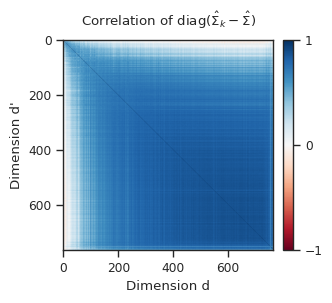

In [10]:
fig = plt.figure(figsize=(3.25, 3))
img_width = 2.1
x_offset = 0.6
y_offset = 0.5
buff = 0.1
ax = create_axis_at_location(fig, x_offset, y_offset, img_width, img_width)
cax = create_axis_at_location(fig, img_width+x_offset+buff, y_offset, .1, img_width)

# Only show lower triangular
lower_triangular = False
mask = None
if lower_triangular:
    mask = torch.triu_indices(corrcoef.shape[0], corrcoef.shape[1], offset=0)
    corrcoef[mask[0], mask[1]] = torch.nan

im = ax.imshow(corrcoef, 
               cmap="RdBu",
            #    cmap="coolwarm",
               vmin=-1, vmax=1)
fig.colorbar(im, cax=cax, ticks=[-1, 0, 1])
if lower_triangular:
    ax.spines[['right', 'top']].set_visible(False)

ax.set_yticks(torch.linspace(0, 600, 4))
ax.set_xticks(torch.linspace(0, 600, 4))
ax.set_xlabel("Dimension d")
ax.set_ylabel("Dimension d'")
ax.set_title(
    "Correlation of $\mathrm{diag}(\hat{\Sigma}_k - \hat{\Sigma})$",
    pad=10,
)

plt.savefig("empirical-cov-diag-corr.pdf")

## Förstner-Moonen Metric


$$\begin{align*}
d(A, B) &= \sqrt{\sum_{i=1}^n \ln^2 \lambda_i (A, B)} \\
\lambda(A,B) &\iff |\lambda A - B| = 0
\end{align*}$$


In [11]:
C = torch.cov(X_tr_raw.T)

evals, evecs = torch.linalg.eigh(C)
evals = evals.flip(0)
evecs = evecs.flip(1)
thresh = evals.max() * C.shape[-1] * 1e-7
keep = torch.zeros(evals.shape[0]).bool()
keep[:128] = True

X_mean = X_tr_raw.mean(0)
proj = lambda X: (X - X_mean) @ evecs[:, keep] / evals[keep].sqrt()
X_tr = proj(X_tr_raw)
X_te = proj(X_te_raw)
covs = torch.stack([torch.cov(X_tr[y_tr == k].T) for k in range(K)])

### Calculate Imagenet class covariance FM distances

In [12]:
DEVICE = "cuda"
covs = covs.to(DEVICE)
Js = torch.linalg.inv(covs)
N = covs.shape[0]
fdists = torch.zeros((N, N), device=DEVICE, dtype=torch.float32)
with tqdm(total=N * (N - 1) * 0.5) as pbar:
    for i in range(covs.shape[0] - 1):
        AB_inv = torch.einsum('ij,kjl->kil', covs[i], Js[i+1:])
        lambdas = torch.linalg.eigvals(AB_inv)
        # lambdas[lambdas < 1e-8] = 1e-8
        fdists[i, i + 1:] = torch.sqrt((torch.log(lambdas) ** 2).sum(1))
        pbar.update(N - i + 1)
fdists = fdists.to("cpu")

  0%|          | 0/499500.0 [00:00<?, ?it/s]

/tmp/ipykernel_3155801/164998769.py:11: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:308.)
  fdists[i, i + 1:] = torch.sqrt((torch.log(lambdas) ** 2).sum(1))


### Calculate FM metric for Wishart samples

In [13]:
# average covariance matrix as Sigma0
Sigma0 = covs.mean(0)
# nu0: number of datapoints
Ns = torch.stack([(y_tr == k).sum() for k in range(K)]).float().to(DEVICE)

nu0 = Ns.mean()
# sample from W
num_samples = 1000
W = torch.distributions.Wishart(df=nu0, covariance_matrix=Sigma0 / nu0)
null_covs = W.sample((num_samples,))
# Calculate Forstner
ncovs_inv = torch.linalg.inv(null_covs)
null_fdists = torch.zeros((num_samples, num_samples), device=DEVICE, requires_grad=False, dtype=torch.float32)
with tqdm(total=num_samples * (num_samples - 1) * 0.5) as pbar:
    for i in range(num_samples - 1):
        AB_inv = torch.einsum('ij,kjl->kil', null_covs[i], ncovs_inv[i+1:])
        lambdas = torch.linalg.eigvals(AB_inv)
        # lambdas[lambdas < 1e-8] = 1e-8
        null_fdists[i, i + 1:] = torch.sqrt((torch.log(lambdas) ** 2).sum(1))
        pbar.update(num_samples - i + 1)
null_fdists = null_fdists.to("cpu")

/home/rwl17/anaconda3/envs/bnp4ood/lib/python3.10/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/499500.0 [00:00<?, ?it/s]

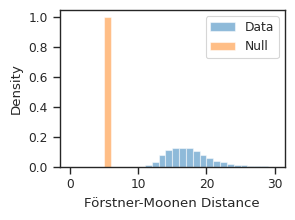

In [15]:
fig, ax = plt.subplots(figsize=(2.75,2))
triu_idxs = torch.triu_indices(K, K, offset=1)
lt_fdists = fdists[triu_idxs[0], triu_idxs[1]]
lt_nullfdists = null_fdists[triu_idxs[0], triu_idxs[1]]
bins = torch.linspace(0, 30, 31)
plt.hist(lt_fdists, bins=bins, alpha=0.5, label="Data", density=True)
plt.hist(lt_nullfdists, bins=bins, alpha=0.5, label="Null", density=True)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Förstner-Moonen Distance')
plt.tight_layout(pad=0)
plt.savefig(f'forstner-dists-vs-null.pdf', bbox_inches='tight')